In [1]:
%load_ext autoreload
%autoreload 2

import numpy
import pandas
import scipy
from matplotlib import pyplot

import calibr8
import murefi

# Fitting Michaelis-Menten kinetics with `calibr8` and `murefi`
Let's assume that you want to model the Michaelis Menten kinetics of an enzymatic assay for estimating the enzymatic activity ($v_{max}$). For this toy example, let's assume that we measured the product at a wavelength of 570 nm.

For the analysis, you need...

1. `calibr8` error model of the $P$ vs. $A_{570}$ correlation
2. correlation data for $P\ [mmol/L]$ vs. measurement readout $A_{570}\ [a.u.]$
3. `murefi` ODE model of Michaelis-Menten kinetics
4. kinetic data of product accumulation (vectors of $t$ and $A_{570}$)

About 75 % of the code in this example is for preparing fake data.

## Preparing Data & Models
### 1. & 2. Error model of product concentration
Because this part is shown in examples for `calibr8`, everything is condensed into one cell.

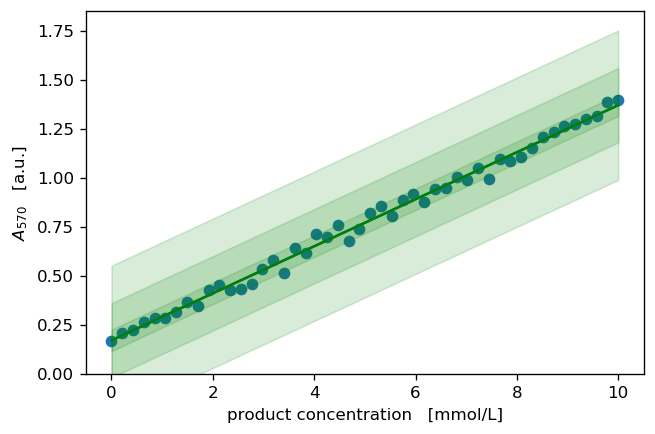

In [2]:
class ProductAssayModel(calibr8.ErrorModel):
    def __init__(self):
        super().__init__('P', 'A570')
        
    def predict_dependent(self, y_hat, *, theta=None):
        if theta is None:
            theta = self.theta_fitted
        mu = theta[0] + theta[1] * numpy.array(y_hat)
        sigma = theta[2]
        return mu, sigma
    
    def predict_independent(self, y_obs):
        a, b, sigma = self.theta_fitted
        mu = (y_obs - a) / b
        return mu

    def loglikelihood(self, *, y,  x, theta=None):
        if theta is None:
            if self.theta_fitted is None:
                raise Exception('No parameter vector was provided and the model is not fitted with data yet.')
            theta = self.theta_fitted

        mu, sigma = self.predict_dependent(x, theta=theta)
        # using Normal-distributed error
        likelihoods = scipy.stats.t.pdf(x=y, loc=mu, scale=sigma, df=1)
        loglikelihoods = numpy.log(likelihoods)
        return numpy.sum(loglikelihoods)

def plot_t_band(ax, d, mu, scale, df=1):
    """Helper function for plotting the likeihood-bands of a t-distribution."""
    ax.plot(d, mu, color='green')
    for q in reversed([97.5, 95, 84]):
        percent = q - (100 - q)
        ax.fill_between(d,
            # by using the Percent Point Function (PPF), which is the inverse of the CDF,
            # the visualization will show symmetric intervals of <percent> probability
            scipy.stats.t.ppf(1-q/100, loc=mu, scale=scale, df=df),
            scipy.stats.t.ppf(q/100, loc=mu, scale=scale, df=df),
            alpha=.15, color='green', label=f'{percent:.1f} % likelihood band'
        )
    return

em_product = ProductAssayModel()
em_product.theta_fitted = (0.17, 0.12, 0.03)

# generate data using the model
corr_x = numpy.linspace(0, 10, 48)
mu, sigma = em_product.predict_dependent(corr_x)
corr_y = numpy.random.normal(mu, sigma)

# plot model and data
fig, ax = pyplot.subplots(dpi=120)

ax.scatter(corr_x, corr_y, label='hypothetical calibration data')
mu, sigma = em_product.predict_dependent(corr_x)
ax.plot(corr_x, mu)
plot_t_band(ax, corr_x, mu, sigma)

ax.set_xlabel('product concentration   [mmol/L]')
ax.set_ylabel('$A_{570}$   [a.u.]')
ax.set_ylim(bottom=0)
pyplot.show()

### 3. ODE Model of enzyme kinetics
To describe the kinetics of our enzyme of interest, we'll use the ODEs of the Michaelis-Menten kinetics:

$$\frac{dP}{dt}= v_{max} \cdot \frac{S}{K_S+S}$$

$$\frac{dS}{dt}=-\frac{dP}{dt}$$

For our data analysis we'll have to implement it with `murefi`:

In [3]:
class MichaelisMentenModel(murefi.BaseODEModel):
    def __init__(self):
        self.guesses = dict(S_0=5, P_0=0, v_max=0.1, K_S=1)
        self.bounds = dict(
            S_0=(1, 20),
            P_0=(0, 10),
            v_max=(0.0001, 5),
            K_S=(0.01, 10),
        )
        super().__init__(independent_keys=['S', 'P'])
        
    def dydt(self, y, t, theta):
        S, P = y
        v_max, K_S = theta
        
        dPdt = v_max * S / (K_S + S)    
        return [
            -dPdt,
            dPdt,
        ]
    
model = MichaelisMentenModel()

### 4. Data of enzymatic reaction
Because this is an example notebook, we'll have to fake our data...
This can be done by
1. simulating a trajectory with our `model` and
2. using the `em_product` to make noisy observations of the product concentrations

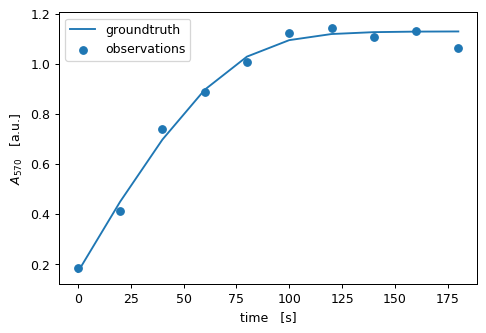

In [4]:
# generate ground truth data at 10 time points
theta_true = (8, 0, 0.16, 2.5)
rep_groundtruth = model.predict_replicate(
    # S_0, P_0, v_max, K_S
    parameters=theta_true,
    template=murefi.Replicate.make_template(tmin=0, tmax=180, independent_keys='SP', iid='A01', N=10)
)

# use error model to make noisy observations of the ground truth
rep_observed = murefi.Replicate(iid='A01')
mu, sigma = em_product.predict_dependent(rep_groundtruth['P'].y)
numpy.random.seed(1234)
rep_observed['A570'] = murefi.Timeseries(
    x=rep_groundtruth['P'].x,
    y=numpy.random.normal(mu, sigma),
    independent_key='P',
    dependent_key='A570'
)
numpy.random.seed(None)

# pack generated data into Dataset
dataset = murefi.Dataset()
dataset[rep_observed.iid] = rep_observed


fig, ax = pyplot.subplots(dpi=90)
ax.scatter(rep_observed['A570'].x, rep_observed['A570'].y, label='observations')
# use error model to project groundtruth onto dependent variable axis
ax.plot(rep_observed['A570'].x, mu, label='groundtruth')
ax.set_xlabel('time   [s]')
ax.set_ylabel('$A_{570}$   [a.u.]')
ax.legend()
pyplot.show()

## Estimation of model parameters
With `murefi`, one can fit an entire dataset while sharing parameters across replicates. The sharing of parameters is achieved via a data structure called `ParameterMapping`.

The `ParameterMapping` is created from a table that maps each replicate in the dataset to a vector of parameters. Parameters that shall remain fixed are set as `float` while flexible parameters are identified by a `str`.

Here, we have just one replicate, so the `ParameterMapping` remains simple:

In [5]:
df_mapping = pandas.DataFrame(columns='rid,S_0,P_0,v_max,K_S'.split(',')).set_index('rid')
# we'll fix S_0=8.0 and fit only the remaining parameters
df_mapping.loc['A01'] = (8.0, 'P_0', 'v_max', 'K_S')

# create the ParameterMapping object
pm = murefi.ParameterMapping(
    df_mapping.reset_index(),
    guesses=model.guesses,      # fed as dict where the key is the name of the parameter
    bounds=model.bounds         # same as guesses
)
print(f'The optimization problem is {pm.ndim}-dimensional.')

df_mapping

The optimization problem is 3-dimensional.


,S_0,P_0,v_max,K_S
rid,,,,
A01,8.0,P_0,v_max,K_S


The `ParameterMapping` object `pm` can now be used to create an optimization objective for a `Dataset` & given a `ParameterMapping`. To connect model predictions with data, it requries a list of `calibr8.ErrorModel`.

Without an error model, the data will not contribute to the fit!

In [6]:
obj = murefi.objectives.for_dataset(
    dataset,
    model,
    pm,
    error_models=[em_product]   # no need for a substrate error model, because there's no data
)

# The objective function can be evaluated at the initial guess to see if everything works as expected:
print(f'Objective at initial guess: {obj(pm.guesses)}')

Objective at initial guess: -9.994635988803509


Now the model can be fitted with `scipy.optimize.minimize`.

If fitting does not work, check the following most common problems:
- objective could evaluate to `nan` (check this with `objective(pm.guesses)`)
- initial guesses might be too unrealistic
- bounds may be too open (invalid predictions, hard to find the optimum)
- bounds may be too restrictive (fit hits the bound)
- bounds may be unrealistic (e.g. not preventing negative $K_S$)
- error models using the $Normal$ distribution often lead to numerical problems

In [7]:
model_fit = scipy.optimize.minimize(
    obj,
    pm.guesses,
    bounds=pm.bounds
)
model_fit

      fun: -17.944455445935304
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.20792265e-05, 3.37009354e-01, 2.29540831e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 152
      nit: 26
   status: 0
  success: True
        x: array([1.41153459, 0.        , 0.13112411])

## Visualizing the optimization result
To visualize the result, we'll use the `ParameterMapping.repmap` method to transform the global parameter vector (3 entries) into a parameter vector for our model (4 entries).
This is necessary, because the global one has a different order and is missing parameters that were fixed.

Then, we can make a high-density prediction using our model:

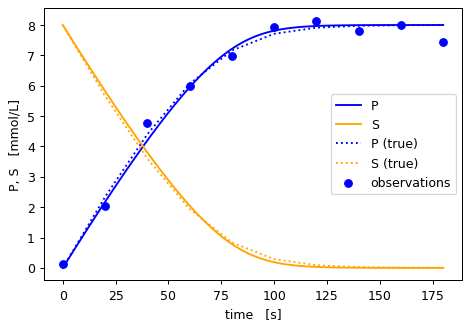

In [8]:
# first make a high-density prediction
rep_fit = model.predict_replicate(
    parameters=pm.repmap(model_fit.x)['A01'],
    template=murefi.Replicate.make_template(tmin=0, tmax=180, independent_keys='SP')
)

fig, ax = pyplot.subplots(dpi=90)
colors = dict(P='blue', S='orange')

# plot data, transformed via the error model into the independent unit
x_obs = rep_observed['A570'].x
y_obs = em_product.predict_independent(rep_observed['A570'].y)
ax.scatter(x_obs, y_obs, label='observations',color=colors['P'])

# plot all timeseries of the fit
for ykey, ts in reversed(rep_fit.items()):
    ax.plot(ts.x, ts.y, label=ykey, color=colors[ykey])
    
# plot all timeseries of the groundtruth for comparison
for ykey, ts in reversed(rep_groundtruth.items()):
    ax.plot(ts.x, ts.y, label=ykey + ' (true)', linestyle=':', color=colors[ykey])

ax.set_xlabel('time   [s]')
ax.set_ylabel('P, S   [mmol/L]')
ax.legend()
pyplot.show()